In [1]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='--conf spark.sql.catalogImplementation=in-memory pyspark-shell'
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.2
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [2]:
from IPython.display import Image

## Pipeline

+ **DataFrame**: This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.


+ **Transformer**: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.


+ **Estimator**: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.


+ **Pipeline**: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.


+ **Parameter**: All Transformers and Estimators now share a common API for specifying parameters.

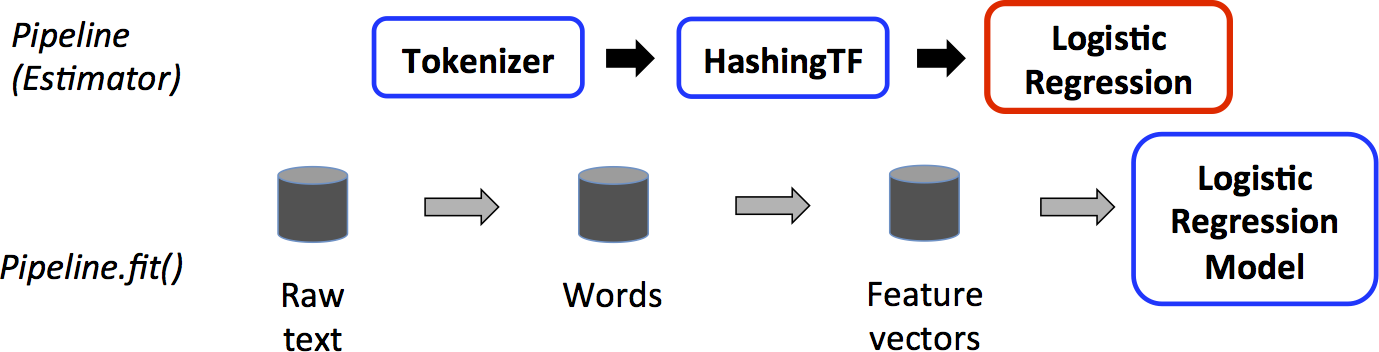

In [3]:
Image("pics/ml-Pipeline.png")

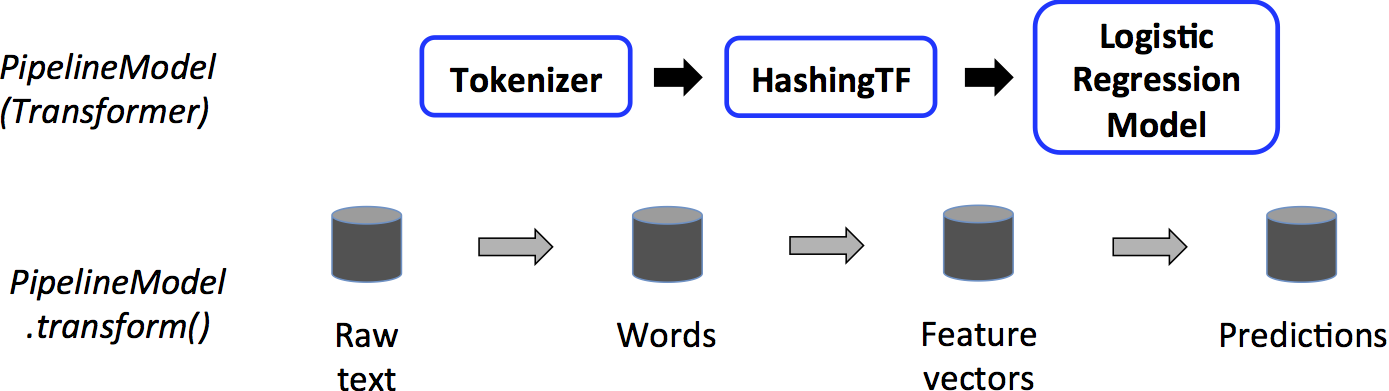

In [4]:
Image("pics/ml-PipelineModel.png")

In [3]:
from pyspark.ml.linalg import Vectors

In [4]:
from pyspark.ml.classification import LogisticRegression

In [5]:
training = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], schema = ["label", "features"])

In [6]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [7]:
lr

LogisticRegression_4c239f5c527cf54f0094

In [8]:
lr.params

[Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_4c239f5c527cf54f0094', name='lowerBoundsOnCoefficients', doc='The 

In [9]:
model = lr.fit(training)

In [10]:
model.coefficients

DenseVector([-3.1009, 2.6082, -0.3802])

In [11]:
model.interceptVector

DenseVector([0.0682])

## Toxic Comment Classification Challenge

In [12]:
from pyspark.sql.types import *

In [13]:
schema = StructType([
    StructField("id", StringType()),
    StructField("comment_text", StringType()),
    StructField("toxic", IntegerType()),
    StructField("severe_toxic", IntegerType()),
    StructField("obscene", IntegerType()),
    StructField("threat", IntegerType()),
    StructField("insult", IntegerType()),
    StructField("identity_hate", IntegerType())
])

In [14]:
dataset = spark.read.csv("/user/pavel.klemenkov/lectures/lecture03/data/train.csv", schema=schema, header=True)

In [16]:
dataset.show(2)

+--------------------+--------------------+-----+------------+-------+------+------+-------------+
|                  id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+--------------------+-----+------------+-------+------+------+-------------+
|    0000997932d777bf|         Explanation| null|        null|   null|  null|  null|         null|
|Why the edits mad...| just closure on ...|    0|           0|      0|     0|     0|            0|
+--------------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 2 rows



## There is an issue with multiline CSVs, fixed in 2.2.0 https://issues.apache.org/jira/browse/SPARK-19610

In [20]:
!head -n3 toxic_comment/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0


In [17]:
dataset = spark.read.csv("/user/pavel.klemenkov/lectures/lecture03/data/train.csv", schema=schema, header=True, multiLine=True)

In [18]:
dataset.select("id").show(10)

+--------------------+
|                  id|
+--------------------+
|    0000997932d777bf|
|    000103f0d9cfb60f|
|    000113f07ec002fd|
|    0001b41b1c6bb37e|
|                More|
|I can't make any ...|
|There appears to ...|
|    0001d958c54c6e35|
|    00025465d4725e87|
|Congratulations f...|
+--------------------+
only showing top 10 rows



## You need to add `escape` parameter!

In [19]:
dataset = spark.read.csv("/user/pavel.klemenkov/lectures/lecture03/data/train.csv", schema=schema, header=True, multiLine=True, escape='"')

In [20]:
dataset.select("id").show(10)

+----------------+
|              id|
+----------------+
|0000997932d777bf|
|000103f0d9cfb60f|
|000113f07ec002fd|
|0001b41b1c6bb37e|
|0001d958c54c6e35|
|00025465d4725e87|
|0002bcb3da6cb337|
|00031b1e95af7921|
|00037261f536c51d|
|00040093b2687caa|
+----------------+
only showing top 10 rows



In [21]:
dataset.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|Explanation
Why t...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man, I'm real...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|"
More
I can't ma...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You, sir, are my ...|    0|           0|      0|     0|     0|            0|
|00025465d4725e87|"

Congratulation...|    0|           0|      0|     0|     0|            0|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|    1|           1|      1|     0|     1|            0|
|00031b1e95af7921|Your vandalism to...|    0|     

In [22]:
dataset.rdd.getNumPartitions()

1

In [23]:
dataset.count()

159571

In [24]:
dataset = dataset.repartition(4).cache()

## Let's define a binary target (toxic/non-toxic)

In [25]:
from pyspark.sql import functions as f

In [26]:
target = f.when(
    (dataset.toxic == 0) &
    (dataset.severe_toxic == 0) &
    (dataset.obscene == 0) &
    (dataset.threat == 0) &
    (dataset.insult == 0) &
    (dataset.identity_hate == 0),
    0
).otherwise(1)

In [27]:
dataset = dataset.withColumn("target", target)

In [28]:
dataset.select("id", "target").show(10)

+----------------+------+
|              id|target|
+----------------+------+
|6fdb7b6734f8bf40|     0|
|26e1b63617df36b1|     0|
|85e4f353ca4b2bde|     0|
|9d2196265213dce8|     0|
|fb7a63a8e287b2d1|     0|
|fd42fd6a1ea341c4|     0|
|54f9e59924682c6e|     0|
|01c0ae884d69319b|     0|
|f7fec98d6aac8ce3|     0|
|25553d990b245467|     1|
+----------------+------+
only showing top 10 rows



In [29]:
dataset.groupBy("target").count().collect()

[Row(target=1, count=16225), Row(target=0, count=143346)]

In [38]:
16225 / (16225 + 143346)

0.10167887648758234

In [30]:
dataset = dataset.drop("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate").cache()

In [31]:
dataset

DataFrame[id: string, comment_text: string, target: int]

In [33]:
dataset.show(10, False, True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id           | 6fdb7b6734f8bf40                                                                                                                                                                                                                                                                                                                                                                                 

In [35]:
dataset.write.parquet("/user/pavel.klemenkov/lectures/lecture03/data/dataset", mode="overwrite")

## Let's fit the simplest binary-BoW logistic regression

In [36]:
from pyspark.ml.feature import *

## Split comments into words

In [37]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

In [38]:
dataset2 = tokenizer.transform(dataset)

In [39]:
dataset2.select("id", "words").show(5, False, True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id    | 6fdb7b6734f8bf40                                                                                                                                                                                                                                                                                   

In [47]:
type(dataset2.take(1)[0].words)

list

## Convert texts into binary vectors using Hashing trick

In [44]:
hasher = HashingTF(numFeatures=100, binary=True, inputCol=tokenizer.getOutputCol(), outputCol="word_vector")
dataset2 = hasher.transform(dataset2)

IllegalArgumentException: 'requirement failed: Column word_vector already exists.'

In [43]:
dataset2.select("id", "word_vector").show(5, False, True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id          | 6fdb7b6734f8bf40                                                                                                                                                                                                                                                                                                                                                                                 
 word_vector | (100,[0,3,5,10,12,13,18,19,20,25,26,28,29,30,31,33,35,36,37,38,42,43,46,47,58,59,60,63,70,72,80,82,85,88,91,96,98,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

## Now let's split into train and test. Don't forget that we have imbalanced classes, so let's do stratified sampling

In [45]:
train = dataset2.sampleBy("target", fractions={0: 0.8, 1: 0.8}, seed=5757)

In [46]:
train.groupby("target").count().collect()

[Row(target=1, count=12906), Row(target=0, count=114769)]

In [48]:
12906 / (12906 + 114769)

0.10108478558840807

In [50]:
test = dataset2.join(train, on="id", how="leftanti")

In [51]:
test.groupby("target").count().collect()

[Row(target=1, count=3319), Row(target=0, count=28577)]

In [52]:
3319 / (3319 + 28577)

0.10405693503887635

In [53]:
train.rdd.getNumPartitions()

4

In [54]:
test.rdd.getNumPartitions()

200

In [55]:
train

DataFrame[id: string, comment_text: string, target: int, words: array<string>, word_vector: vector]

In [56]:
train = train.drop("comment_text", "words").cache()

In [57]:
test = test.drop("comment_text", "words").repartition(4).cache()

## Let's fit logistic regression

In [58]:
from pyspark.ml.classification import LogisticRegression

In [59]:
lr = LogisticRegression(featuresCol=hasher.getOutputCol(), labelCol="target", maxIter=15)

In [60]:
lr_model = lr.fit(train)

In [62]:
predictions = lr_model.transform(test)

In [63]:
predictions

DataFrame[id: string, target: int, word_vector: vector, rawPrediction: vector, probability: vector, prediction: double]

In [65]:
predictions.select("id", "target", "prediction", "probability", "rawPrediction").show(20, False, True)

-RECORD 0--------------------------------------------------
 id            | 33ef813bc6274b5d                          
 target        | 0                                         
 prediction    | 0.0                                       
 probability   | [0.985556882259044,0.014443117740956024]  
 rawPrediction | [4.222988823916378,-4.222988823916378]    
-RECORD 1--------------------------------------------------
 id            | fe7b1f2bd3756b0b                          
 target        | 0                                         
 prediction    | 0.0                                       
 probability   | [0.8519904791908007,0.14800952080919919]  
 rawPrediction | [1.7502987506212653,-1.7502987506212653]  
-RECORD 2--------------------------------------------------
 id            | 378b2fb2a572952b                          
 target        | 0                                         
 prediction    | 0.0                                       
 probability   | [0.9660920045456195,0.0

In [66]:
predictions.select("target", f.col("prediction").cast("int")).filter("target == prediction").count()

28612

In [67]:
predictions.count()

31896

In [68]:
print("Accuracy is {}".format(28668 / 31896))

Accuracy is 0.8987960872836719


In [70]:
lr.getThreshold()

0.5

## What if we want more sophisticated metrics?

In [69]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [70]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="target", metricName='areaUnderROC')

In [71]:
evaluator.evaluate(predictions)

0.516989977855192

In [72]:
evaluator.setParams(metricName="areaUnderPR")

BinaryClassificationEvaluator_4f22a0fc04edd0d9b248

In [73]:
evaluator.evaluate(predictions)

0.352371180782395

In [76]:
lr.getThreshold()

0.5

In [74]:
evaluator.setParams(metricName="precision")

BinaryClassificationEvaluator_4f22a0fc04edd0d9b248

In [75]:
evaluator.evaluate(predictions)

IllegalArgumentException: 'BinaryClassificationEvaluator_4f22a0fc04edd0d9b248 parameter metricName given invalid value precision.'

## `spark.ml.evaluation.BinaryClassificationEvaluator` supports only ROC AUC and PR AUC. What if we want more?

In [76]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [77]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="accuracy")

In [78]:
evaluator.evaluate(predictions)

0.8970403812390269

In [79]:
evaluator = evaluator.setMetricName("weightedPrecision")

In [83]:
evaluator.evaluate(predictions)

0.8662299348750517

In [84]:
evaluator = evaluator.setMetricName("weightedRecall")

In [85]:
evaluator.evaluate(predictions)

0.8970403812390269

In [88]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix, roc_curve

In [81]:
predictions_df = predictions.toPandas()

RuntimeError: Unsupported type in conversion to Arrow: VectorUDT
Note: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true. Please set it to false to disable this.

In [82]:
spark.conf.set("spark.sql.execution.arrow.enabled", False)

In [83]:
predictions_df = predictions.toPandas()

In [84]:
precision_score(predictions_df.target, predictions_df.prediction.astype("int"))

0.5829383886255924

In [87]:
recall_score(predictions_df.target, predictions_df.prediction.astype("int"))

0.037059355227478157

In [86]:
confusion_matrix(predictions_df.target, predictions_df.prediction.astype("int"))

array([[28489,    88],
       [ 3196,   123]])

In [104]:
curve = roc_curve(predictions_df.target, predictions_df.prediction, pos_label=1)

In [ ]:
evaluator = BinaryClassificationEvaluator()

In [98]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


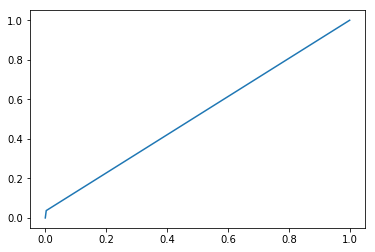

In [105]:
plt.plot(curve[0], curve[1])

In [95]:
predictions.select("target", f.col("prediction").cast("int")).filter("target = 1").count()

3319

In [96]:
predictions_df.head()

,id,target,word_vector,rawPrediction,probability,prediction
0,1c91aef081632d2f,0,"(1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[3.28672208081589, -3.28672208081589]","[0.9639704804001281, 0.03602951959987193]",0.0
1,e5c7518fad813933,0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[2.001421646194293, -2.001421646194293]","[0.8809462609223833, 0.11905373907761674]",0.0
2,e7d81da4ecd75ce9,0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.7183260425827276, -1.7183260425827276]","[0.8479130943859283, 0.15208690561407168]",0.0
3,efd07c9dd3b3d970,0,"(1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[3.0574172813713387, -3.0574172813713387]","[0.9551016736928989, 0.04489832630710122]",0.0
4,d63205f51c28d877,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.1344930710919243, -1.1344930710919243]","[0.7566671260069274, 0.24333287399307257]",0.0


## Let's define a pipeline!

In [106]:
dataset = spark.read.parquet("/user/pavel.klemenkov/lectures/lecture03/data/dataset")

In [107]:
dataset

DataFrame[id: string, comment_text: string, target: int]

In [108]:
dataset.rdd.getNumPartitions()

4

In [109]:
from pyspark.ml import Pipeline

In [110]:
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    lr
])

In [111]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}).cache()

In [112]:
test = dataset.join(train, on="id", how="leftanti").cache()

In [113]:
pipeline_model = pipeline.fit(train)

In [114]:
predictions = pipeline_model.transform(test)

In [115]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="target", metricName='areaUnderROC')

In [116]:
evaluator.evaluate(predictions)

0.5179360215935078

## Okay, may be some more sophisticated stuff?

In [117]:
from pyspark.ml.classification import GBTClassifier

In [118]:
gbt = GBTClassifier(featuresCol=hasher.getOutputCol(), labelCol="target", maxIter=10)

In [119]:
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    gbt
])

In [120]:
pipeline_model = pipeline.fit(train)

In [121]:
predictions = pipeline_model.transform(test)

In [122]:
evaluator.evaluate(predictions)

0.5011141811196853

## Lets add more degrees of freedom

In [123]:
pipeline_model.stages

[Tokenizer_426f8b0b5b4add74609a,
 HashingTF_4e6aa91aff516ac74140,
 GBTClassificationModel (uid=GBTClassifier_4871800cc351e716153c) with 10 trees]

In [124]:
pipeline_model = pipeline.fit(train, params={hasher.numFeatures: 1000})

In [ ]:
pipeline_model.stages[1].extractParamMap()

In [125]:
predictions = pipeline_model.transform(test)

In [126]:
evaluator.evaluate(predictions)

0.5890628097750682

## Let's remove stopwords

In [127]:
stop_words = StopWordsRemover.loadDefaultStopWords("english")

In [128]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [129]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words_filtered", stopWords=stop_words)

In [130]:
hasher = HashingTF(numFeatures=1000, binary=True, inputCol=swr.getOutputCol(), outputCol="word_vector")

In [137]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    hasher,
    lr
])

In [138]:
pipeline_model = pipeline.fit(train)

In [139]:
pipeline_model.stages

[Tokenizer_426f8b0b5b4add74609a,
 StopWordsRemover_4a8c8f78eb6bf3bb9634,
 HashingTF_4c54a61981eac6322d21,
 LogisticRegression_4b38af966784f73b3e02]

In [140]:
predictions = pipeline_model.transform(test)

In [141]:
evaluator.evaluate(predictions)

0.6388673644123688

## Need moar features!

In [144]:
import pyspark.sql.functions as f

In [149]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- target: integer (nullable = true)
 |-- comment_length: integer (nullable = true)



In [145]:
dataset = dataset.withColumn("comment_length", f.length(dataset.comment_text))

In [150]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}).cache()
test = dataset.join(train, on="id", how="leftanti").cache()

In [151]:
train

DataFrame[id: string, comment_text: string, target: int, comment_length: int]

In [152]:
assembler = VectorAssembler(inputCols=[hasher.getOutputCol(), "comment_length"], outputCol="features")

In [153]:
lr = LogisticRegression(labelCol="target", maxIter=15)

In [154]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    hasher,
    assembler,
    lr
])

In [155]:
pipeline_model = pipeline.fit(train)

In [156]:
pipeline_model.stages

[Tokenizer_426f8b0b5b4add74609a,
 StopWordsRemover_4a8c8f78eb6bf3bb9634,
 HashingTF_4c54a61981eac6322d21,
 VectorAssembler_459f95be78d5737963d2,
 LogisticRegression_4ae08f9bdc46702cd43f]

In [157]:
predictions = pipeline_model.transform(test)

In [158]:
evaluator.evaluate(predictions)

0.6448055761196295

In [ ]:
pipeline_model.stages[-1].coefficients[-1]

## Ok, how do you do it right!? https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52557

## Very funny, anyway?

In [159]:
count_vectorizer = CountVectorizer(inputCol=swr.getOutputCol(), outputCol="word_vector", binary=True)

In [162]:
assembler = VectorAssembler(inputCols=[count_vectorizer.getOutputCol(), "comment_length"], outputCol="features")

In [163]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    count_vectorizer,
    assembler,
    lr
])

In [164]:
pipeline_model = pipeline.fit(train)

In [165]:
predictions = pipeline_model.transform(test)

In [166]:
evaluator.evaluate(predictions)

0.8263767315919899

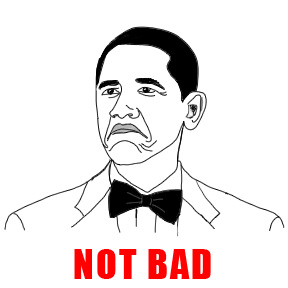

In [131]:
Image("pics/Obama_not_bad.png")

## Hyperparameter tuning

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
paramGrid = ParamGridBuilder().addGrid(count_vectorizer.vocabSize, [100, 500, 1000])\
                              .addGrid(lr.regParam, [0.01, 0.05, 0.1])\
                              .build()

In [ ]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, parallelism=7)

In [ ]:
cv_model = crossval.fit(train)

In [ ]:
cv_model.

In [ ]:
predictions = cv_model.transform(test)

In [ ]:
evaluator.evaluate(predictions)

In [1]:
spark.stop()

NameError: name 'spark' is not defined